Please fill out:
* Student name: Thien Nguyen
* Student pace: self paced 
* Scheduled project review date/time: 10/19/18, 5:30pm-6:15pm
* Instructor name: Eli Thomas
* Blog post URL: https://tthien92.github.io/feature_selection_in_data_analysis

# STEP 1: OBTAIN DATA

All libraries and functions predicted to be nececssary are imported. Afterwards, target data is imported and displayed via pandas dataframe.


In [316]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [317]:
df = pd.read_csv('kc_house_data.csv')
df.shape # (21597, 21)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


The data reveals 21597 entries of houses corresponding to 21 different attributes. Since all data is allocated in one file, there is no need to query from multiple sources or merge data. From a business perspective, future clientele will most likely want to understand what attributes influence the price of a home. Therefore, the target will be price.

# STEP 2: SCRUB DATA

In this step, the following will be achieved:
- Ensuring columns are the right data types
- Identifying and dealing with null value
- Determining multicollinearity and removing necessary columns
- Normalizing Data

### Dealing with Null Values

In [318]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [319]:
sum(df['yr_renovated'] == 0)

17011

The year renovated column possesses values of 0's, which is a placeholder value for null. Collectively, this means that most of the data for year renovated is null, so dropping the column entirely is reasonable. In addition, there are only 63 null values in view, so those will rows also be dropped. Lastly, the null values for waterfront will be replaced with the median since that is the most common category. 

In [320]:
df.drop('yr_renovated', axis = 1, inplace = True)  # drops yr_renovated column
df.waterfront.fillna(df.waterfront.median(), inplace = True) #fills NaN in Waterfront with median
df.dropna(inplace = True) #drops remaining NaN in view column
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### Ensuring Correct Data Types

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 20 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_above       21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
zipcode          21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
dtypes: float64(7), int64(11), object(2)
memory usage: 3.5+ MB


Potential issues with the data so far:
- the sqft of the basement is a str, but should be an int.
- view, zipcode, waterfront, grade, and condition should all be categorical data and should be converted to str

In [322]:
pd.to_numeric(df['sqft_basement']) # reveals '?' string within sqft basement column
df.view = df.view.astype('str') 
df.zipcode = df.zipcode.astype('str')
df.waterfront = df.waterfront.astype('str')
df.grade = df.grade.astype('str')
df.condition = df.condition.astype('str')

ValueError: Unable to parse string "?" at position 6

In [323]:
sum(df['sqft_basement'] =='?') #454 instances of '?' for sqft basement
df = df.drop(df[df['sqft_basement']=='?'].index) #We drop these entries since it makes up only 2% of the data

In [324]:
sum(df['sqft_basement'] =='?') #verify that there are no more '?' in the sqft_basement

0

In [325]:
df['sqft_basement'] = pd.to_numeric(df['sqft_basement']) #try this step again

In [326]:
df.view = df.view.astype('str')
df.zipcode = df.zipcode.astype('str')
df.waterfront = df.waterfront.astype('str')
df.grade = df.grade.astype('str')
df.condition = df.condition.astype('str')

In [327]:
len(df.id.unique()) # returns 20909. Since this means most ids are unique to a house, this column serves little purpose

20909

In [328]:
df.drop('id', axis = 1, inplace = True)

In [329]:
df.drop(['sqft_living15', 'sqft_lot15'], axis = 1, inplace = True) # These columns are redundant since yr_renov is already dropped

In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 17 columns):
date             21082 non-null object
price            21082 non-null float64
bedrooms         21082 non-null int64
bathrooms        21082 non-null float64
sqft_living      21082 non-null int64
sqft_lot         21082 non-null int64
floors           21082 non-null float64
waterfront       21082 non-null object
view             21082 non-null object
condition        21082 non-null object
grade            21082 non-null object
sqft_above       21082 non-null int64
sqft_basement    21082 non-null float64
yr_built         21082 non-null int64
zipcode          21082 non-null object
lat              21082 non-null float64
long             21082 non-null float64
dtypes: float64(6), int64(5), object(6)
memory usage: 2.9+ MB


In [331]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long
count,2.108200e+04,21082.000000,21082.000000,21082.000000,2.108200e+04,21082.00000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000
mean,5.402469e+05,3.372403,2.115916,2080.359975,1.507759e+04,1.49362,1789.000000,291.359975,1971.023337,47.560371,-122.213843
std,3.667323e+05,0.924996,0.768142,917.856396,4.117338e+04,0.53937,828.369355,442.007858,29.323120,0.138568,0.140607
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.00000,370.000000,0.000000,1900.000000,47.155900,-122.519000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.00000,1200.000000,0.000000,1952.000000,47.471325,-122.328000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.50000,1560.000000,0.000000,1975.000000,47.572200,-122.230000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.069775e+04,2.00000,2210.000000,560.000000,1997.000000,47.678200,-122.125000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.50000,9410.000000,4820.000000,2015.000000,47.777600,-121.315000


### Assessing Multicollinearity

Judging from the information above, there does not seem to be any more placeholder null values, so we can proceed with identifying multicollinearity

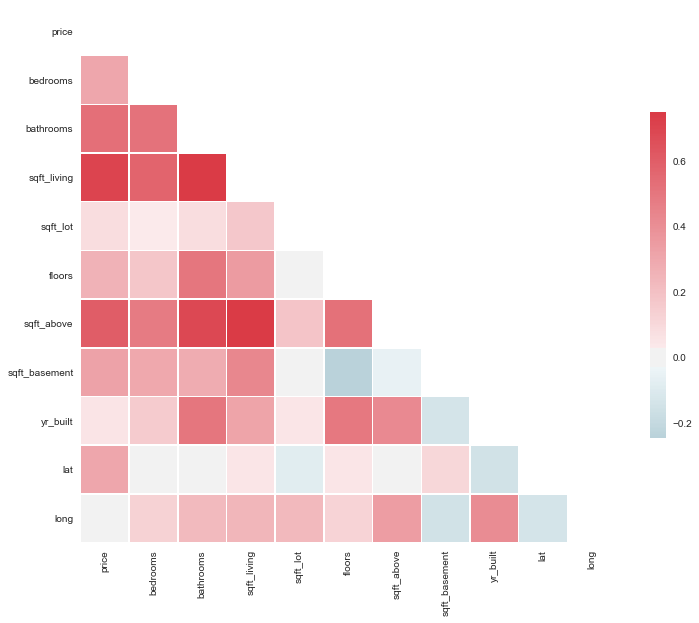

In [332]:
sns.set(style = 'white')

corr = df.corr()

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize= (12,12))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .75, center = 0, square = True, linewidth = .5, cbar_kws = {'shrink':.5})

In [333]:
abs(df.corr()) > .75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long
price,True,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,False
sqft_living,False,False,True,True,False,False,True,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False
sqft_above,False,False,False,True,False,False,True,False,False,False,False
sqft_basement,False,False,False,False,False,False,False,True,False,False,False
yr_built,False,False,False,False,False,False,False,False,True,False,False
lat,False,False,False,False,False,False,False,False,False,True,False


The heatmap suggests that both the sqft of the living room and the sqft of the basement may cause collinearity. Further inspection with an absolute correlation value of .75 suggest that sqft living room is highly correlated with the bathrooms & sqft above, so dropping this column is wise.

In [334]:
df.drop('sqft_living', axis = 1, inplace = True)
df.drop('date', axis = 1, inplace = True) #date is not necessary for a generalized model either
df.head()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long
0,221900.0,3,1.00,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,98178,47.5112,-122.257
1,538000.0,3,2.25,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,98125,47.7210,-122.319
2,180000.0,2,1.00,10000,1.0,0.0,0.0,3,6,770,0.0,1933,98028,47.7379,-122.233
3,604000.0,4,3.00,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,98136,47.5208,-122.393
4,510000.0,3,2.00,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,98074,47.6168,-122.045


### Normalizing Data


In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 15 columns):
price            21082 non-null float64
bedrooms         21082 non-null int64
bathrooms        21082 non-null float64
sqft_lot         21082 non-null int64
floors           21082 non-null float64
waterfront       21082 non-null object
view             21082 non-null object
condition        21082 non-null object
grade            21082 non-null object
sqft_above       21082 non-null int64
sqft_basement    21082 non-null float64
yr_built         21082 non-null int64
zipcode          21082 non-null object
lat              21082 non-null float64
long             21082 non-null float64
dtypes: float64(6), int64(4), object(5)
memory usage: 2.6+ MB


In [336]:
df = pd.get_dummies(df) #one-hot encoding to deal with categorical data via binning
df.head()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,3,1.00,5650,1.0,1180,0.0,1955,47.5112,-122.257,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,3,2.25,7242,2.0,2170,400.0,1951,47.7210,-122.319,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,10000,1.0,770,0.0,1933,47.7379,-122.233,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,5000,1.0,1050,910.0,1965,47.5208,-122.393,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,8080,1.0,1680,0.0,1987,47.6168,-122.045,...,0,0,0,0,0,0,0,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024A0A6B87F0>,
      dtype=object)

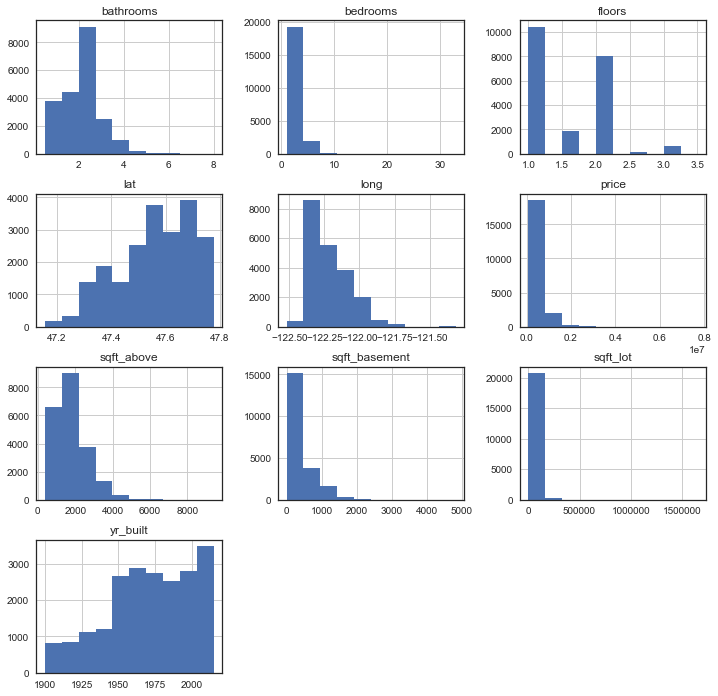

In [337]:
df_cont = df.iloc[:,0:10]
df_cont.hist(figsize=(12,12))

In [338]:
df.describe()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
count,2.108200e+04,21082.000000,21082.000000,2.108200e+04,21082.00000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,...,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000
mean,5.402469e+05,3.372403,2.115916,1.507759e+04,1.49362,1789.000000,291.359975,1971.023337,47.560371,-122.213843,...,0.013187,0.002609,0.020634,0.011764,0.012380,0.011906,0.012238,0.006214,0.012807,0.014847
std,3.667323e+05,0.924996,0.768142,4.117338e+04,0.53937,828.369355,442.007858,29.323120,0.138568,0.140607,...,0.114076,0.051012,0.142158,0.107823,0.110578,0.108465,0.109949,0.078584,0.112444,0.120942
min,7.800000e+04,1.000000,0.500000,5.200000e+02,1.00000,370.000000,0.000000,1900.000000,47.155900,-122.519000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,5.040000e+03,1.00000,1200.000000,0.000000,1952.000000,47.471325,-122.328000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,7.620000e+03,1.50000,1560.000000,0.000000,1975.000000,47.572200,-122.230000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,1.069775e+04,2.00000,2210.000000,560.000000,1997.000000,47.678200,-122.125000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.700000e+06,33.000000,8.000000,1.651359e+06,3.50000,9410.000000,4820.000000,2015.000000,47.777600,-121.315000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [339]:
skew_var= ['price','sqft_above', 'bathrooms', 'bedrooms', 'sqft_lot'] #log transform to reduce skewness
#sqft_basement has many zeros and longitude has negative values, so log transform would not work.
#price itself is also heavily skewed, so applying log transformation may reduce skewness


In [340]:
for var in skew_var:
    df[var]= np.log(df[var])
df.describe()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
count,21082.000000,21082.000000,21082.000000,21082.000000,21082.00000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,...,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000
mean,13.048217,1.177712,0.677803,8.990663,1.49362,7.395389,291.359975,1971.023337,47.560371,-122.213843,...,0.013187,0.002609,0.020634,0.011764,0.012380,0.011906,0.012238,0.006214,0.012807,0.014847
std,0.526394,0.282684,0.392118,0.901414,0.53937,0.427009,442.007858,29.323120,0.138568,0.140607,...,0.114076,0.051012,0.142158,0.107823,0.110578,0.108465,0.109949,0.078584,0.112444,0.120942
min,11.264464,0.000000,-0.693147,6.253829,1.00000,5.913503,0.000000,1900.000000,47.155900,-122.519000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.682307,1.098612,0.559616,8.525161,1.00000,7.090077,0.000000,1952.000000,47.471325,-122.328000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.017003,1.098612,0.810930,8.938532,1.50000,7.352441,0.000000,1975.000000,47.572200,-122.230000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.377006,1.386294,0.916291,9.277789,2.00000,7.700748,560.000000,1997.000000,47.678200,-122.125000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.856731,3.496508,2.079442,14.317109,3.50000,9.149528,4820.000000,2015.000000,47.777600,-121.315000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024A0F162EB8>,
      dtype=object)

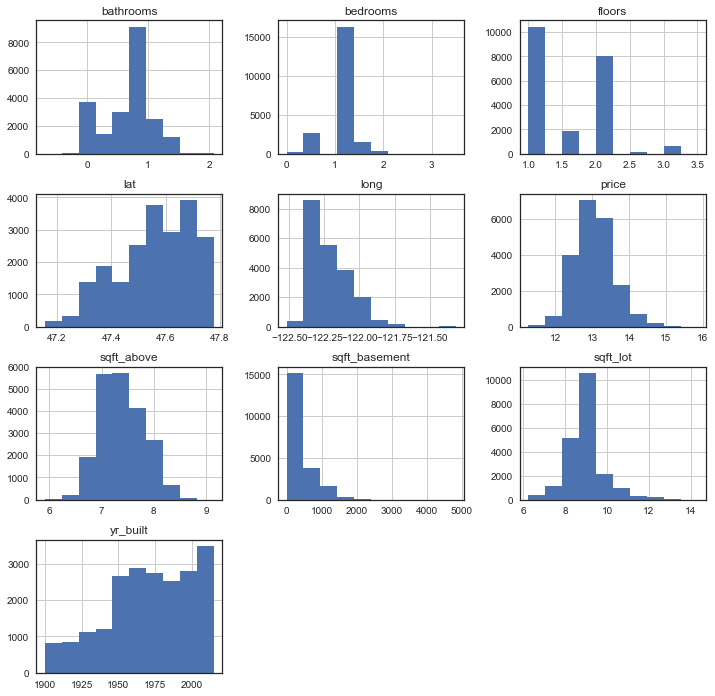

In [341]:
df_cont = df.iloc[:,0:10]
df_cont.hist(figsize=(12,12))

In [342]:
#standardize all continuous data to z-score
cont_data = ['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'lat','long']
for item in cont_data:
    df[item] = (df[item] - df[item].mean())/df[item].std()



Now that all objectives for scrubbing the data has been met, it is time to explore the data.

# STEP 3: EXPLORE DATA

In [343]:
df.describe()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
count,21082.000000,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,2.108200e+04,...,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000,21082.000000
mean,13.048217,2.485392e-13,-2.282493e-13,-4.924482e-14,-2.007930e-14,2.384871e-13,-5.826506e-15,8.573079e-16,3.342675e-13,-5.259425e-12,...,0.013187,0.002609,0.020634,0.011764,0.012380,0.011906,0.012238,0.006214,0.012807,0.014847
std,0.526394,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.114076,0.051012,0.142158,0.107823,0.110578,0.108465,0.109949,0.078584,0.112444,0.120942
min,11.264464,-4.166173e+00,-3.496268e+00,-3.036158e+00,-9.151785e-01,-3.470388e+00,-6.591737e-01,-2.422093e+00,-2.918930e+00,-2.170286e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.682307,-2.798151e-01,-3.014067e-01,-5.164131e-01,-9.151785e-01,-7.150016e-01,-6.591737e-01,-6.487487e-01,-6.426134e-01,-8.118877e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.017003,-2.798151e-01,3.395084e-01,-5.783302e-02,1.182833e-02,-1.005779e-01,-6.591737e-01,1.356153e-01,8.536787e-02,-1.149085e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.377006,7.378647e-01,6.082042e-01,3.185282e-01,9.388352e-01,7.151120e-01,6.077721e-01,8.858765e-01,8.503345e-01,6.318550e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.856731,8.202777e+00,3.574532e+00,5.908993e+00,3.719856e+00,4.107971e+00,1.024561e+01,1.499727e+00,1.567671e+00,6.392602e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [344]:
df_cont = df.iloc[:,1:10]
df_cont.head()

,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long
0,-0.279815,-1.728568,-0.389668,-0.915179,-0.754362,-0.659174,-0.546440,-0.354849,-0.306933
1,-0.279815,0.339508,-0.114277,0.938835,0.672337,0.245788,-0.682852,1.159208,-0.747879
2,-1.714154,-1.728568,0.243703,-0.915179,-1.754058,-0.659174,-1.296702,1.281170,-0.136245
3,0.737865,1.073170,-0.525253,-0.915179,-1.027715,1.399613,-0.205413,-0.285569,-1.274170
4,-0.279815,0.039132,0.007193,-0.915179,0.072974,-0.659174,0.544849,0.407231,1.200818


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024A78047588>,
      dtype=object)

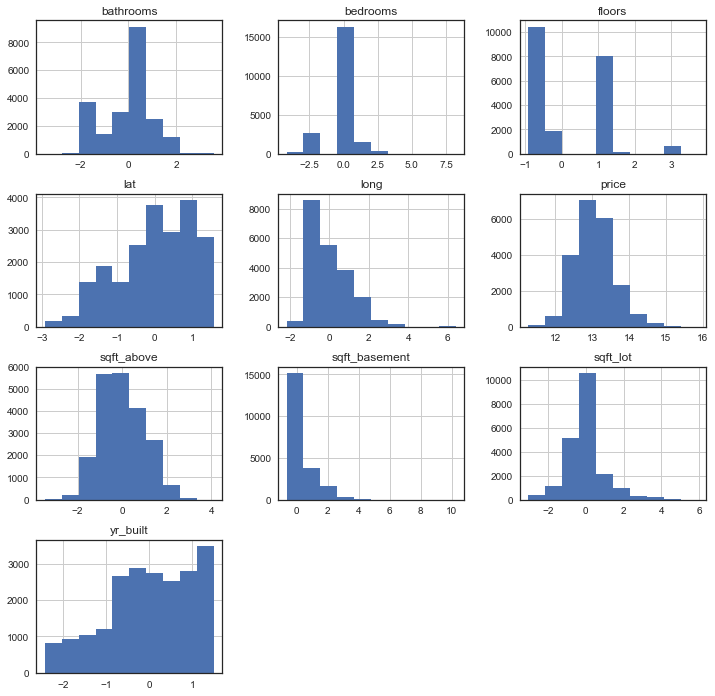

In [345]:
#The simplest way to start EDA is with the .hist function on the continuous variables to allow for some easy visualization
df_cont = df.iloc[:,0:10]
df_cont.hist(figsize=(12,12))

#### Preliminary Analysis
Most of the data breaks normality, except for sqft_lot, price, and sqft_above. There is some skewness with some of the data, and outliers in some columns (e.g. bedrooms, sqft basement, sqft lot, etc). 

C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Thien Nguyen\Anaconda3\lib\site

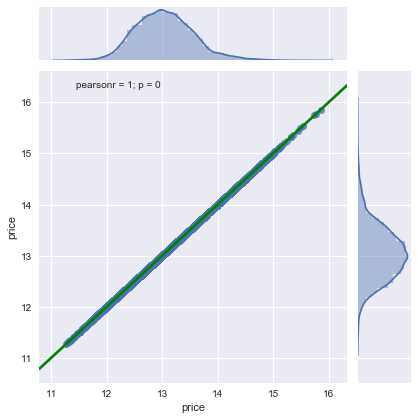

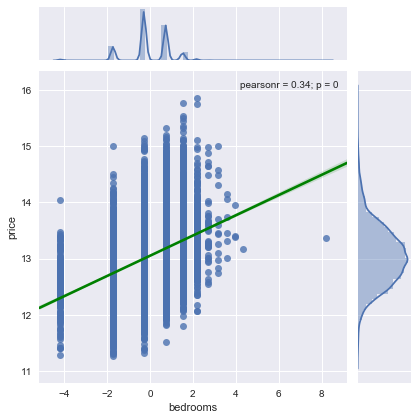

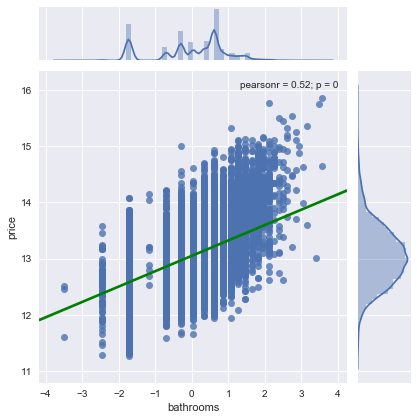

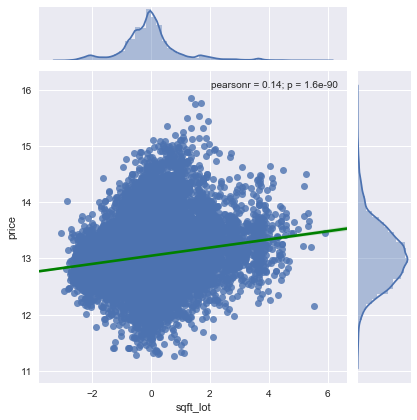

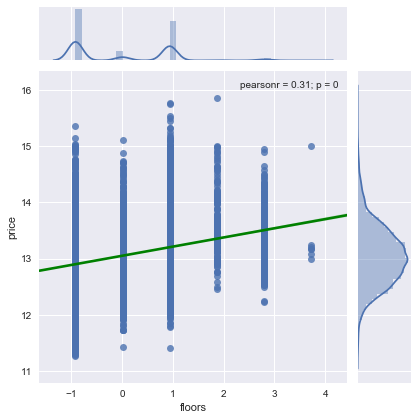

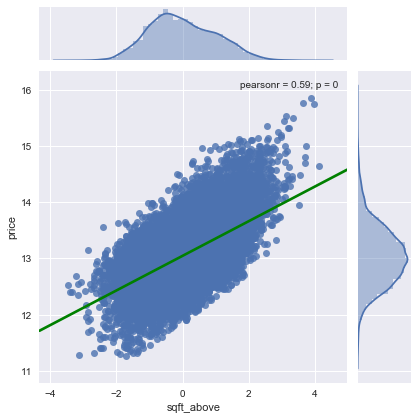

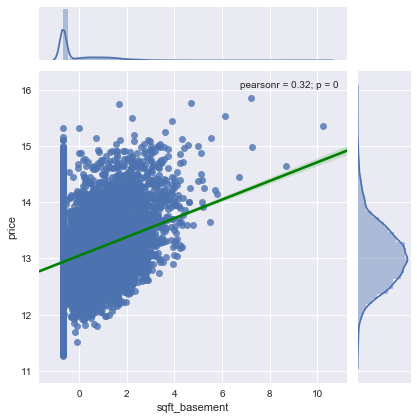

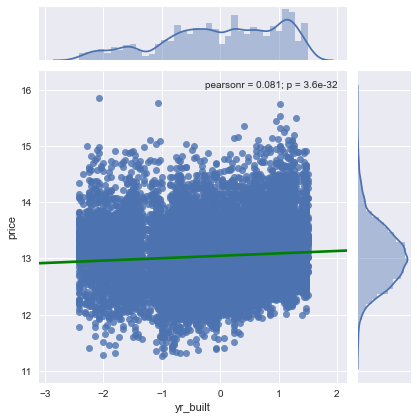

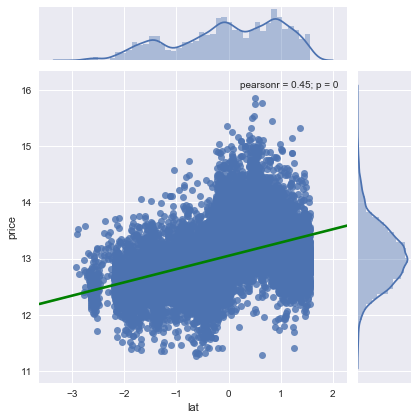

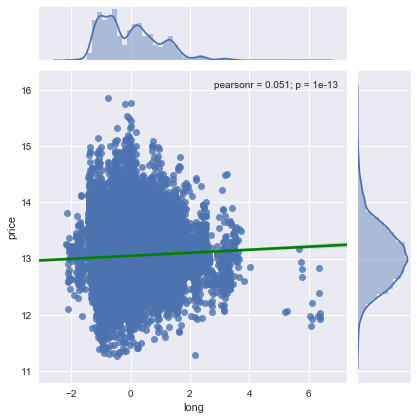

In [346]:
plt.style.use('seaborn')
for col in list(df_cont.columns):
    sns.jointplot(x = df[col], y = df['price'], data = df, kind = 'reg', label = col, joint_kws={'line_kws':{'color':'green'}})

- Most of the data has some moderate correlation with the price
- Strong correlation with bathrooms & sqft_above & latitude
- Bedrooms, Bathrooms, floors, and latitude seem to be multimodal. The first three make sense since the data is discrete, but it is interesting that latitude is also multimodal
- Obvious outliers in bedrooms warrants removal
- Normality somewhat holds only for sqft_lot and sqft_above.
- long & yr_built seem to have no linear relation with price

### Iterative Changes
Outliers will be dropped to reduce skewness and increase normality within the data.

In [347]:
df.drop(df[df.bedrooms==df.bedrooms.max()].index, axis = 0, inplace = True) # drops outlier for bedroom
df.describe()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
count,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,...,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000
mean,13.048201,-0.000389,0.000014,0.000015,0.000043,0.000050,-0.000031,0.000039,-0.000044,0.000040,...,0.013187,0.002609,0.020635,0.011764,0.012381,0.011906,0.012239,0.006214,0.012808,0.014847
std,0.526401,0.998426,1.000022,1.000021,1.000004,0.999998,1.000014,1.000008,1.000004,1.000007,...,0.114079,0.051013,0.142161,0.107825,0.110581,0.108468,0.109951,0.078586,0.112447,0.120945
min,11.264464,-4.166173,-3.496268,-3.036158,-0.915179,-3.470388,-0.659174,-2.422093,-2.918930,-2.170286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.682307,-0.279815,-0.301407,-0.516413,-0.915179,-0.715002,-0.659174,-0.648749,-0.642794,-0.811888,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.017003,-0.279815,0.339508,-0.057833,0.011828,-0.100578,-0.659174,0.135615,0.085368,-0.114908,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.377006,0.737865,0.608204,0.318554,0.938835,0.715112,0.607772,0.885876,0.850335,0.631855,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.856731,4.316419,3.574532,5.908993,3.719856,4.107971,10.245610,1.499727,1.567671,6.392602,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# STEP 4: MODEL DATA

In [348]:
df.iloc[:,0:10].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21081 entries, 0 to 21596
Data columns (total 10 columns):
price            21081 non-null float64
bedrooms         21081 non-null float64
bathrooms        21081 non-null float64
sqft_lot         21081 non-null float64
floors           21081 non-null float64
sqft_above       21081 non-null float64
sqft_basement    21081 non-null float64
yr_built         21081 non-null float64
lat              21081 non-null float64
long             21081 non-null float64
dtypes: float64(10)
memory usage: 1.8 MB


In [349]:
for category in df.iloc[:,10:].columns:   #converts data to category
         df[category] = df[category].astype('category')

In [350]:
#check to see that data is converted
df.iloc[:,11:35].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21081 entries, 0 to 21596
Data columns (total 24 columns):
waterfront_1.0    21081 non-null category
view_0.0          21081 non-null category
view_1.0          21081 non-null category
view_2.0          21081 non-null category
view_3.0          21081 non-null category
view_4.0          21081 non-null category
condition_1       21081 non-null category
condition_2       21081 non-null category
condition_3       21081 non-null category
condition_4       21081 non-null category
condition_5       21081 non-null category
grade_10          21081 non-null category
grade_11          21081 non-null category
grade_12          21081 non-null category
grade_13          21081 non-null category
grade_3           21081 non-null category
grade_4           21081 non-null category
grade_5           21081 non-null category
grade_6           21081 non-null category
grade_7           21081 non-null category
grade_8           21081 non-null category
grade_9  

In [351]:
df.describe()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long
count,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000
mean,13.048201,-0.000389,0.000014,0.000015,0.000043,0.000050,-0.000031,0.000039,-0.000044,0.000040
std,0.526401,0.998426,1.000022,1.000021,1.000004,0.999998,1.000014,1.000008,1.000004,1.000007
min,11.264464,-4.166173,-3.496268,-3.036158,-0.915179,-3.470388,-0.659174,-2.422093,-2.918930,-2.170286
25%,12.682307,-0.279815,-0.301407,-0.516413,-0.915179,-0.715002,-0.659174,-0.648749,-0.642794,-0.811888
50%,13.017003,-0.279815,0.339508,-0.057833,0.011828,-0.100578,-0.659174,0.135615,0.085368,-0.114908
75%,13.377006,0.737865,0.608204,0.318554,0.938835,0.715112,0.607772,0.885876,0.850335,0.631855
max,15.856731,4.316419,3.574532,5.908993,3.719856,4.107971,10.245610,1.499727,1.567671,6.392602


### Modeling with Continuous Data

A simple OLS regression will be constructed for each continuous variable. The r-squared, intercept, slope, and p-value for each independent variable will be stored 

In [352]:
col_name = df.describe().columns.drop('price')
results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
for index, val in enumerate(col_name):
    f = 'price~'+ val
    model = smf.ols(formula = f, data = df).fit()
    X_new = pd.DataFrame({val: [df[val].min(), df[val].max()]});
    preds = model.predict(X_new)
    results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1]])


In [353]:
pd.DataFrame(results)

,0,1,2,3,4
0,ind_var,r_squared,intercept,slope,p-value
1,bedrooms,0.117122,13.0483,0.180435,0
2,bathrooms,0.270009,13.0482,0.273525,0
3,sqft_lot,0.0191295,13.0482,0.0728047,1.5472e-90
4,floors,0.0961094,13.0482,0.163192,0
5,sqft_above,0.343242,13.0482,0.308403,0
6,sqft_basement,0.0999965,13.0482,0.166458,0
7,yr_built,0.00659426,13.0482,0.0427461,3.49817e-32
8,lat,0.202074,13.0482,0.23663,0
9,long,0.00262567,13.0482,0.0269733,9.74437e-14


#### Analysis:
- None of the continuous variables have p-values > .05. This means that the chance of correlation being 0% is less than 5%, thus being statistically significant.
- R-squared for bathrooms, sqft_above, and sqft_basement are particularly high which suggests that these variables are good predictors in explaining the variability of the price. This seems logical as sqft_above represents the square footage of a house excluding the basement, and bigger house (more expensive) houses tend to have more bathrooms. Basements also tend to be a luxury in modern homes. 
- Longitude and year-built seem to be particularly weak indicators. This also makes sense as longitude does not vary with climate, which is a factor often considered in home purchasing. The year built of a home may not matter so much as many homes are often rennovated through the years

### Modeling with Categorical Data

In [354]:
#One column for each categorical data is dropped to avoid a singularity occurring 
df_waterfront = df.columns[11:12]
df_view = df.columns[13:17]
df_condition = df.columns[18:22]
df_grade = df.columns[23:33]
df_zip = df.columns[34:]

cols = [df_waterfront, df_view, df_condition, df_grade, df_zip]
for col in cols:
    sum_cols = "+".join(col)
    f = "price ~" + sum_cols
    model = smf.ols(formula= f, data= df).fit()
    print(model.summary())



SyntaxError: invalid syntax (<unknown>, line 1)

It seems that the decimal in both waterfront and view is triggering a syntax error. These columns should be renamed.

In [355]:
df.rename(columns={'waterfront_0.0':'waterfront_0',
                   'waterfront_1.0':'waterfront_1',
                          'view_0.0':'view_0',
                            'view_1.0':'view_1',
                    'view_2.0':'view_2',
                    'view_3.0':'view_3',
                    'view_4.0':'view_4',}, inplace=True)


In [356]:
#One column for each categorical data is dropped to avoid a singularity occurring 
df_waterfront = df.columns[11:12]
df_view = df.columns[13:17]
df_condition = df.columns[18:22]
df_grade = df.columns[23:33]
df_zip = df.columns[34:]

cols = [df_waterfront, df_view, df_condition, df_grade, df_zip]
for col in cols:
    sum_cols = "+".join(col)
    f = "price ~" + sum_cols
    model = smf.ols(formula= f, data= df).fit()
    print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     619.2
Date:                Mon, 17 Dec 2018   Prob (F-statistic):          9.63e-135
Time:                        16:01:39   Log-Likelihood:                -16079.
No. Observations:               21081   AIC:                         3.216e+04
Df Residuals:                   21079   BIC:                         3.218e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.0409      0.00

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     344.9
Date:                Mon, 17 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:01:39   Log-Likelihood:                -8402.4
No. Observations:               21081   AIC:                         1.694e+04
Df Residuals:                   21011   BIC:                         1.750e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.4957      0

#### Categorical Data Analysis
- The presence of a waterfront only explains about 3% of the variability with price
- View count (or so I believe?) explains about 12% of the variability with (supposedly) more views impacting the price
- Surprisingly, the condition of the house had minimal influence on the price, while the grade assigned by the King County grading system accounted for almost 50% of the pricing variability
- Zip code also accounted for a lot of variability, but certain specific zip codes exceeded the p<.05 threshold, thus proving to be statistically questionable as features. In addition, the sheer number of zip codes may prove problematic in constructing the final model

In [357]:

#Such a big number of categorical data with zip codes may create collinearity. It may be best to use this data as a separate 
#model altogether and compare the two at the end.
df_zip = df.drop(['long', 'yr_built', 'waterfront_0', 'view_0', 'condition_1', 'grade_10'], axis = 1)

#continuous data with an r-squared >.01 is dropped along with one column from each categorical dataset
df_final = df[df.columns[:33].get_values().tolist()]
df_final = df_final.drop(['long', 'yr_built', 'waterfront_0', 'view_0', 'condition_1', 'grade_10'], axis = 1)

df_final

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,lat,waterfront_1,view_1,...,grade_11,grade_12,grade_13,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9
0,12.309982,-0.279815,-1.728568,-0.389668,-0.915179,-0.754362,-0.659174,-0.354849,0,0,...,0,0,0,0,0,0,0,1,0,0
1,13.195614,-0.279815,0.339508,-0.114277,0.938835,0.672337,0.245788,1.159208,0,0,...,0,0,0,0,0,0,0,1,0,0
2,12.100712,-1.714154,-1.728568,0.243703,-0.915179,-1.754058,-0.659174,1.281170,0,0,...,0,0,0,0,0,0,1,0,0,0
3,13.311329,0.737865,1.073170,-0.525253,-0.915179,-1.027715,1.399613,-0.285569,0,0,...,0,0,0,0,0,0,0,1,0,0
4,13.142166,-0.279815,0.039132,0.007193,-0.915179,0.072974,-0.659174,0.407231,0,0,...,0,0,0,0,0,0,0,0,1,0
5,14.022525,0.737865,2.107208,2.819326,-0.915179,2.039246,2.802303,0.690846,0,0,...,1,0,0,0,0,0,0,0,0,0
8,12.343658,-0.279815,-1.728568,-0.079889,-0.915179,-1.027715,0.992381,-0.346910,0,0,...,0,0,0,0,0,0,0,1,0,0
9,12.685408,-0.279815,0.608204,-0.224001,0.938835,0.348806,-0.659174,-1.385389,0,0,...,0,0,0,0,0,0,0,1,0,0
10,13.403776,-0.279815,0.608204,0.220838,-0.915179,0.311336,3.186912,0.291043,0,0,...,0,0,0,0,0,0,0,0,1,0
11,13.056224,-1.714154,-1.728568,-0.322991,-0.915179,-1.495183,0.019547,0.935491,0,0,...,0,0,0,0,0,0,0,1,0,0


### Stepwise Selection

In [392]:
y = np.asarray(df_final['price'])
X = df_final.drop(['price'], axis = 1)
predictors = sm.add_constant(X)

In [393]:
df_final.head()

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_above,sqft_basement,lat,waterfront_1,view_1,...,grade_11,grade_12,grade_13,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9
0,12.309982,-0.279815,-1.728568,-0.389668,-0.915179,-0.754362,-0.659174,-0.354849,0,0,...,0,0,0,0,0,0,0,1,0,0
1,13.195614,-0.279815,0.339508,-0.114277,0.938835,0.672337,0.245788,1.159208,0,0,...,0,0,0,0,0,0,0,1,0,0
2,12.100712,-1.714154,-1.728568,0.243703,-0.915179,-1.754058,-0.659174,1.281170,0,0,...,0,0,0,0,0,0,1,0,0,0
3,13.311329,0.737865,1.073170,-0.525253,-0.915179,-1.027715,1.399613,-0.285569,0,0,...,0,0,0,0,0,0,0,1,0,0
4,13.142166,-0.279815,0.039132,0.007193,-0.915179,0.072974,-0.659174,0.407231,0,0,...,0,0,0,0,0,0,0,0,1,0


In [360]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward`-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [394]:
result = stepwise_selection(predictors.astype(float), y.astype(float))
print('Features:')
print(result)

Add  bedrooms                       with p-value 0.0
Add  grade_11                       with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  const                          with p-value 0.0
Add  view_4                         with p-value 1.238e-159
Add  grade_7                        with p-value 1.46157e-96
Add  grade_6                        with p-value 1.7623e-143
Add  grade_8                        with p-value 1.04616e-171
Add  grade_5                        with p-value 1.01562e-160
Add  condition_3                    with p-value 3.52779e-141
Add  grade_9                        with p-value 1.26756e-73
Add  view_3                         with p-value 1.25905e-63
Add  view_2                         with p-value 6.27837e-73
Add  grade_4                        with p-value 3.95185e-50
Add  waterfront_1                   with p-value 6.16782e-48
Add  view

In [362]:
for item in result: 
    if item in(X.columns):
        pass
    else:
        print(item)

const


It seems like all of our predictors are statistically significant, according to stepwise selection. Next, stepwise selection results will be cross-referenced with RFE.

### Feature Ranking with RFE

In [363]:
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 20)
selector = selector.fit(X, y)

In [364]:
selected_columns = X.columns[selector.support_]
selected_columns
rfe_list = selected_columns.get_values().tolist()

#Stepwise and RFE gives us different lists of predictors to include. Lets see which ones are different.
for item in result: 
    if item in(rfe_list):
        pass
    else:
        print(item)

bedrooms
const
sqft_lot
bathrooms


#### Analysis
RFE states that bedrooms, sqft_lot, and bathrooms are the least important features within our model, which seems very counterintuitive. Since stepwise selection states that they are still statistically significant, and it is only 3 additional features, the final model will retain these predictors.

In [395]:
result.remove('const') #since this is not the in columns

In [397]:

formula = 'price ~'
for feature in result:
    formula += '{} +'.format(feature)
formula += 'grade_9' #have to add manually or else the for-loop ends with a '+' sign


formula_1
smf.ols(formula=formula, data=df_final).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     2639.
Date:                Mon, 17 Dec 2018   Prob (F-statistic):               0.00
Time:                        21:19:05   Log-Likelihood:                -2086.1
No. Observations:               21081   AIC:                             4220.
Df Residuals:                   21057   BIC:                             4411.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.3171      0.022    615.630      0.000      13.275      13.359
grade_11[T.1]         0.1600      0.016     10.075      0.000       0.129       0.191
view_4[T.1]           0.2974      0.019     15.650      0.000       0.260       0.335
grade_7[T.1]         -0.5258      0.011    -49.850      0.000      -0.546      -0.505
grade_6[T.1]         -0.6473      0.013    -49.309      0.000      -0.673      -0.622
grade_8[T.1]         -0.3738      0.010    -38.777      0.000      -0.393      -0.355
grade_5[T.1]         -0.7486      0.022    -34.748      0.000      -0.791      -0.706
condition_3[T.1]      0.0780      0.020      3.967      0.000       0.039       0.116
grade_9[T.1]         -0.1726      0.010    -17.639      0.000      -0.192      -0.153
view_3[T.1]           0.2319      0.013     18.477      0.000       0.207       0.257
view_2[T.1]           0.1705      0.009     18.571      0.000       0.153       0.189
grade_4[T.1]         -0.7562      0.053    -14.138      0.000      -0.861      -0.651
waterfront_1[T.1]     0.4174      0.027     15.180      0.000       0.364       0.471
view_1[T.1]           0.2135      0.015     14.190      0.000       0.184       0.243
condition_5[T.1]      0.2692      0.021     13.113      0.000       0.229       0.309
grade_12[T.1]         0.3472      0.030     11.581      0.000       0.288       0.406
condition_4[T.1]      0.1746      0.020      8.840      0.000       0.136       0.213
grade_13[T.1]         0.6004      0.075      7.999      0.000       0.453       0.748
bedrooms             -0.0173      0.003     -6.909      0.000      -0.022      -0.012
sqft_above            0.1800      0.004     46.252      0.000       0.172       0.188
lat                   0.2064      0.002    108.005      0.000       0.203       0.210
sqft_basement         0.0946      0.002     39.443      0.000       0.090       0.099
sqft_lot             -0.0140      0.002     -6.626      0.000      -0.018      -0.010
bathrooms             0.0088      0.003      2.903      0.004       0.003       0.015
==============================================================================
Omnibus:                      434.995   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              660.724
Skew:                           0.220   Prob(JB):                    3.35e-144
Kurtosis:                       3.747   Cond. No.                         63.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Ensuring Model Fit

The above model's parameters are all statistically significant, and with a adjusted r-squared of .742, it explains much of the variability within the price. However, it is still necessary to test the model's fit to ensure that it can adequately predict new data as well. 

### Test-Train-Split

In [313]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)
test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

0.07080975177855302

Since test-train-split has some level of variance depending on which section of the data is sampled, k-fold cross validation with 20 folds will also be used. This limits the variance since the MSE for each fold will be averaged. 

### K-Fold Cross Validation

In [314]:
cv_20_results = cross_val_score(linreg, X, y, cv=20, scoring="neg_mean_squared_error")
print(cv_20_results)
print(np.mean(cv_20_results))

[-0.06812241 -0.074362   -0.07085126 -0.08489064 -0.07350715 -0.07311299
 -0.07057717 -0.07529035 -0.07240392 -0.06898902 -0.07006055 -0.07990278
 -0.0717607  -0.07717531 -0.07507136 -0.07498257 -0.07535882 -0.072871
 -0.05442297 -0.04882939]
-0.07162711853527273


### Analysis
The MSE for both test-train-split and K-fold Cross Validation is relatively low. This suggests that the model is adept at making predictions about new data, given that it at least follow expected trends. In addition, no chunk of the data seems to be inflated either

### Examining a model with zip codes

In [398]:
y_zip = np.asarray(df_zip['price'])
X_zip = df_zip.drop(['price'], axis = 1)
predictors = sm.add_constant(X_zip)
result_zip = stepwise_selection(predictors.astype(float), y_zip.astype(float))
print(result_zip)

Add  sqft_basement                  with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  const                          with p-value 0.0
Add  zipcode_98004                  with p-value 2.88871e-250
Add  view_4                         with p-value 1.06551e-203
Add  zipcode_98040                  with p-value 3.72996e-173
Add  zipcode_98112                  with p-value 1.63569e-173
Add  zipcode_98155                  with p-value 9.72184e-147
Add  zipcode_98133                  with p-value 6.83626e-141
Add  zipcode_98028                  with p-value 7.69239e-144
Add  zipcode_98019                  with p-value 4.4645e-152
Add  view_3                         with p-value 1.73711e-125
Add  view_2                         with p-value 6.8339e-119
Add  zipcode_98034                  with p-value 2.44429e-120
Add  zipcode_98011                  with p-value 3.6761

C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  zipcode_98007                  with p-value 2.68292e-14
Drop zipcode_98052                  with p-value 0.43623
Add  zipcode_98001                  with p-value 1.26075e-07
Add  zipcode_98002                  with p-value 5.04404e-10
Add  zipcode_98003                  with p-value 3.00684e-09
Add  zipcode_98092                  with p-value 2.27309e-10
Add  zipcode_98148                  with p-value 3.28552e-07
Add  bedrooms                       with p-value 1.16518e-06
Add  zipcode_98052                  with p-value 1.82559e-06
Drop zipcode_98053                  with p-value 0.418897
Add  zipcode_98074                  with p-value 2.00023e-09
Drop zipcode_98022                  with p-value 0.675149
Add  zipcode_98038                  with p-value 1.42605e-07
Drop zipcode_98108                  with p-value 0.144808
Add  zipcode_98053                  with p-value 0.000405814
Drop zipcode_98177                  with p-value 0.887405
Add  zipcode_98065                  with

In [401]:
result_zip.remove('const')

In [402]:

formula_zip = 'price ~'
for feature in result_zip:
    formula_zip += '{} +'.format(feature)
formula_zip += 'zipcode_98075' #have to add manually or else the for-loop ends with a '+' sign


formula_zip
smf.ols(formula=formula_zip, data=df_zip).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     1737.
Date:                Mon, 17 Dec 2018   Prob (F-statistic):               0.00
Time:                        22:34:22   Log-Likelihood:                 5899.7
No. Observations:               21081   AIC:                        -1.162e+04
Df Residuals:                   20992   BIC:                        -1.091e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.8992      0.036    355.206      0.000      12.828      12.970
zipcode_98004[T.1]     0.7092      0.013     52.646      0.000       0.683       0.736
view_4[T.1]            0.3017      0.013     22.840      0.000       0.276       0.328
zipcode_98040[T.1]     0.5014      0.013     38.827      0.000       0.476       0.527
zipcode_98112[T.1]     0.6684      0.015     45.691      0.000       0.640       0.697
zipcode_98155[T.1]    -0.0938      0.018     -5.318      0.000      -0.128      -0.059
zipcode_98133[T.1]    -0.0351      0.017     -2.124      0.034      -0.068      -0.003
zipcode_98028[T.1]    -0.1031      0.019     -5.457      0.000      -0.140      -0.066
zipcode_98019[T.1]    -0.1975      0.020     -9.985      0.000      -0.236      -0.159
view_3[T.1]            0.1875      0.009     21.446      0.000       0.170       0.205
view_2[T.1]            0.1182      0.006     18.450      0.000       0.106       0.131
zipcode_98011[T.1]    -0.0689      0.020     -3.400      0.001      -0.109      -0.029
zipcode_98072[T.1]    -0.0411      0.019     -2.162      0.031      -0.078      -0.004
zipcode_98125[T.1]     0.0853      0.016      5.285      0.000       0.054       0.117
zipcode_98039[T.1]     0.8750      0.028     31.337      0.000       0.820       0.930
zipcode_98168[T.1]    -0.2626      0.012    -21.160      0.000      -0.287      -0.238
zipcode_98077[T.1]    -0.0835      0.020     -4.131      0.000      -0.123      -0.044
zipcode_98014[T.1]    -0.1914      0.020     -9.440      0.000      -0.231      -0.152
zipcode_98178[T.1]    -0.1874      0.012    -15.053      0.000      -0.212      -0.163
waterfront_1[T.1]      0.4373      0.019     22.994      0.000       0.400       0.475
zipcode_98119[T.1]     0.5994      0.017     35.561      0.000       0.566       0.632
zipcode_98116[T.1]     0.4036      0.012     32.684      0.000       0.379       0.428
zipcode_98136[T.1]     0.3452      0.013     26.701      0.000       0.320       0.371
zipcode_98006[T.1]     0.2651      0.010     25.293      0.000       0.245       0.286
zipcode_98109[T.1]     0.6096      0.020     30.144      0.000       0.570       0.649
zipcode_98122[T.1]     0.4424      0.014     32.288      0.000       0.416       0.469
zipcode_98102[T.1]     0.5777      0.021     27.945      0.000       0.537       0.618
zipcode_98199[T.1]     0.4528      0.014     31.481      0.000       0.425       0.481
zipcode_98105[T.1]     0.5367      0.016     33.009      0.000       0.505       0.569
grade_7[T.1]          -0.3162      0.008    -41.614      0.000      -0.331      -0.301
grade_6[T.1]          -0.3975      0.009    -42.206      0.000      -0.416      -0.379
grade_8[T.1]          -0.2239      0.007    -32.836      0.000      -0.237      -0.211
grade_5[T.1]          -0.4689      0.0

In [389]:
len(result) # 88 predictors in the model with zip codes

88

In [390]:
cv_20_results_zip = cross_val_score(linreg, X_zip, y_zip, cv=20, scoring="neg_mean_squared_error")
print(cv_20_results_zip)
print(np.mean(cv_20_results_zip))

[-2.95848340e-02 -3.61992143e-02 -2.50356410e+15 -3.81160098e-02
 -3.41353802e-02 -3.34740336e-02 -3.13052661e-02 -4.01867083e-02
 -3.53345669e-02 -2.99463920e-02 -3.31247112e-02 -3.81425120e-02
 -3.52209415e-02 -3.48784684e-02 -3.61335712e-02 -3.44914585e-02
 -3.49392055e-02 -3.30520194e-02 -2.87311949e-02 -2.76118365e-02]
-125178205226064.67


There's definitely one fold that is a huge outlier with the rest of the data. This causes the data to have a huge average MSE

# STEP 5: INTERPRET DATA

### Final Model Evaluation

In [404]:
smf.ols(formula=formula, data=df_final).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     2639.
Date:                Mon, 17 Dec 2018   Prob (F-statistic):               0.00
Time:                        22:34:47   Log-Likelihood:                -2086.1
No. Observations:               21081   AIC:                             4220.
Df Residuals:                   21057   BIC:                             4411.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.3171      0.022    615.630      0.000      13.275      13.359
grade_11[T.1]         0.1600      0.016     10.075      0.000       0.129       0.191
view_4[T.1]           0.2974      0.019     15.650      0.000       0.260       0.335
grade_7[T.1]         -0.5258      0.011    -49.850      0.000      -0.546      -0.505
grade_6[T.1]         -0.6473      0.013    -49.309      0.000      -0.673      -0.622
grade_8[T.1]         -0.3738      0.010    -38.777      0.000      -0.393      -0.355
grade_5[T.1]         -0.7486      0.022    -34.748      0.000      -0.791      -0.706
condition_3[T.1]      0.0780      0.020      3.967      0.000       0.039       0.116
grade_9[T.1]         -0.1726      0.010    -17.639      0.000      -0.192      -0.153
view_3[T.1]           0.2319      0.013     18.477      0.000       0.207       0.257
view_2[T.1]           0.1705      0.009     18.571      0.000       0.153       0.189
grade_4[T.1]         -0.7562      0.053    -14.138      0.000      -0.861      -0.651
waterfront_1[T.1]     0.4174      0.027     15.180      0.000       0.364       0.471
view_1[T.1]           0.2135      0.015     14.190      0.000       0.184       0.243
condition_5[T.1]      0.2692      0.021     13.113      0.000       0.229       0.309
grade_12[T.1]         0.3472      0.030     11.581      0.000       0.288       0.406
condition_4[T.1]      0.1746      0.020      8.840      0.000       0.136       0.213
grade_13[T.1]         0.6004      0.075      7.999      0.000       0.453       0.748
bedrooms             -0.0173      0.003     -6.909      0.000      -0.022      -0.012
sqft_above            0.1800      0.004     46.252      0.000       0.172       0.188
lat                   0.2064      0.002    108.005      0.000       0.203       0.210
sqft_basement         0.0946      0.002     39.443      0.000       0.090       0.099
sqft_lot             -0.0140      0.002     -6.626      0.000      -0.018      -0.010
bathrooms             0.0088      0.003      2.903      0.004       0.003       0.015
==============================================================================
Omnibus:                      434.995   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              660.724
Skew:                           0.220   Prob(JB):                    3.35e-144
Kurtosis:                       3.747   Cond. No.                         63.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With an adjusted R-square of .74, the final model adequately predicts sales price, while also ensuring each predictor is statistically significant. There are, however, some surprising findings along with some expected results:

- Any grade 9 or lower had a detrimental impact on the housing price. A grade of 13 had the biggest positive impact on price. 
- A view of 4 had the highest impact on price out of the views, but it is unclear if more views were necessarily better. The original dataset did not elaborate on what each view meant specifically
- Condition somewhat led to high prices, but not as much as the grade received from the county grading system.
- Increases in bedrooms actually have a negative impact on price, but since the coefficient is small, this suggest that there may be an optimum amount of bedrooms to have.
- Sqft lot interestingly also has a negative relationship with price. One reasoning is that perhaps houses built on a big lot tend to be further away from the city center, which actually drives down prices. 
- Latitude and sqft above also have a moderate positive relationship with price. This suggest that the north part of the county tends to have more expensive housing. The latter is logical as living space (apart from basement) is a huge consideration in price. 
- Bathrooms don't seem to impact price much at all, even though there is a slight positive relationship. Again, this suggest there is an optimum number of bathrooms for most people.

### Evaluating the Zip Code Model

In [403]:
smf.ols(formula=formula_zip, data=df_zip).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     1737.
Date:                Mon, 17 Dec 2018   Prob (F-statistic):               0.00
Time:                        22:34:26   Log-Likelihood:                 5899.7
No. Observations:               21081   AIC:                        -1.162e+04
Df Residuals:                   20992   BIC:                        -1.091e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.8992      0.036    355.206      0.000      12.828      12.970
zipcode_98004[T.1]     0.7092      0.013     52.646      0.000       0.683       0.736
view_4[T.1]            0.3017      0.013     22.840      0.000       0.276       0.328
zipcode_98040[T.1]     0.5014      0.013     38.827      0.000       0.476       0.527
zipcode_98112[T.1]     0.6684      0.015     45.691      0.000       0.640       0.697
zipcode_98155[T.1]    -0.0938      0.018     -5.318      0.000      -0.128      -0.059
zipcode_98133[T.1]    -0.0351      0.017     -2.124      0.034      -0.068      -0.003
zipcode_98028[T.1]    -0.1031      0.019     -5.457      0.000      -0.140      -0.066
zipcode_98019[T.1]    -0.1975      0.020     -9.985      0.000      -0.236      -0.159
view_3[T.1]            0.1875      0.009     21.446      0.000       0.170       0.205
view_2[T.1]            0.1182      0.006     18.450      0.000       0.106       0.131
zipcode_98011[T.1]    -0.0689      0.020     -3.400      0.001      -0.109      -0.029
zipcode_98072[T.1]    -0.0411      0.019     -2.162      0.031      -0.078      -0.004
zipcode_98125[T.1]     0.0853      0.016      5.285      0.000       0.054       0.117
zipcode_98039[T.1]     0.8750      0.028     31.337      0.000       0.820       0.930
zipcode_98168[T.1]    -0.2626      0.012    -21.160      0.000      -0.287      -0.238
zipcode_98077[T.1]    -0.0835      0.020     -4.131      0.000      -0.123      -0.044
zipcode_98014[T.1]    -0.1914      0.020     -9.440      0.000      -0.231      -0.152
zipcode_98178[T.1]    -0.1874      0.012    -15.053      0.000      -0.212      -0.163
waterfront_1[T.1]      0.4373      0.019     22.994      0.000       0.400       0.475
zipcode_98119[T.1]     0.5994      0.017     35.561      0.000       0.566       0.632
zipcode_98116[T.1]     0.4036      0.012     32.684      0.000       0.379       0.428
zipcode_98136[T.1]     0.3452      0.013     26.701      0.000       0.320       0.371
zipcode_98006[T.1]     0.2651      0.010     25.293      0.000       0.245       0.286
zipcode_98109[T.1]     0.6096      0.020     30.144      0.000       0.570       0.649
zipcode_98122[T.1]     0.4424      0.014     32.288      0.000       0.416       0.469
zipcode_98102[T.1]     0.5777      0.021     27.945      0.000       0.537       0.618
zipcode_98199[T.1]     0.4528      0.014     31.481      0.000       0.425       0.481
zipcode_98105[T.1]     0.5367      0.016     33.009      0.000       0.505       0.569
grade_7[T.1]          -0.3162      0.008    -41.614      0.000      -0.331      -0.301
grade_6[T.1]          -0.3975      0.009    -42.206      0.000      -0.416      -0.379
grade_8[T.1]          -0.2239      0.007    -32.836      0.000      -0.237      -0.211
grade_5[T.1]          -0.4689      0.0

This model has an adjusted R-squared of .879, but it most likely suffers from dimensionality due to 88 predictors being included. Compared to the final model, it is much more kurtic and less normal (according to JB). However, the one main benefit of this model would be the additional information obtaniable from zip codes (i.e. it is possible to see which zip codes tend to have higher housing price). This alone may justify this model depending on the client's interests. However, the model would be poor at predicting future prices due to high disparity with MSE given by crossout validation.
